# Model Evaluation

This file captures the results of different model runs and evaluates the best performance in prediction on test data after parameter tuning.

### Data Preparation

The keystroke dynamics data from 20 users are first selected and pre-processed before the learning starts.  The data are first split in 20/80 for testing / training dataset.  The data are then scaled, followed by dimensional reduction.

In [129]:
# Import all required libraries
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

# Import algorithm library
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#### Loading Data and Selection on Features and Subjects

In [130]:
# Load dataset and extract first 20 subjects
whole_dataset = pd.read_csv('DSL-StrongPasswordData.csv')

first_20subject = (whole_dataset.groupby(by='subject', axis=0).count().index[:20])
selected_dataset = whole_dataset[whole_dataset['subject'].isin(first_20subject)]

# The DD and UD timings of each key have been showed to be highly correlated to each other 
# in a separate analysis. Hence, we will drop all features starting with 'DD'
all_features = selected_dataset.columns[3:34]
selected_features = [x for x in all_features if not x.startswith('DD')]

# Get a copy of dataset with selected feature columns
df = selected_dataset[selected_features].copy()
# df['subject'] = selected_dataset['subject']

# Show samples
df.head()

# Get feature columns
#feature_data = selected_dataset[selected_features]

,H.period,UD.period.t,H.t,UD.t.i,H.i,UD.i.e,H.e,UD.e.five,H.five,UD.five.Shift.r,...,UD.Shift.r.o,H.o,UD.o.a,H.a,UD.a.n,H.n,UD.n.l,H.l,UD.l.Return,H.Return
0,0.1491,0.2488,0.1069,0.0605,0.1169,0.1043,0.1417,1.0468,0.1146,1.4909,...,0.6523,0.1016,0.1120,0.1349,0.0135,0.0932,0.2583,0.1338,0.2171,0.0742
1,0.1111,0.2340,0.0694,0.0589,0.0908,0.0449,0.0829,1.1141,0.0689,0.7133,...,0.6307,0.1066,0.0618,0.1412,0.1146,0.1146,0.1496,0.0839,0.1917,0.0747
2,0.1328,0.0744,0.0731,0.0560,0.0821,0.0721,0.0808,0.9600,0.0892,0.5311,...,0.5741,0.1365,0.1566,0.1621,0.0711,0.1172,0.1533,0.1085,0.1762,0.0945
3,0.1291,0.1224,0.1059,0.1436,0.1040,0.0998,0.0900,0.9656,0.0913,1.1651,...,0.6096,0.0956,0.0574,0.1457,0.0172,0.0866,0.1475,0.0845,0.2387,0.0813
4,0.1249,0.1068,0.0895,0.0781,0.0903,0.0686,0.0805,0.7824,0.0742,0.8213,...,0.6389,0.0430,0.1545,0.1312,0.0270,0.0884,0.1633,0.0903,0.1614,0.0818


#### Perform training and test data splitting

In [131]:
X_train, X_test, y_train, y_test = train_test_split(df, selected_dataset['subject'],test_size=0.20, random_state=42, stratify=selected_dataset['subject'])
X_train.shape

(6400, 21)

#### Perform scaling on feature values

In [132]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [133]:
# To store best performing model
eval_results = pd.DataFrame({"Accuracy" : []})


# Single Algorithm Models

In [134]:
# Create a new Experiment to capture logs
experiment_id = mlflow.create_experiment("Model Evaluation Experiment")

## 1) Experiments with Decision Tree Classifier

In [135]:
Model_Name = "DECISION TREE"
with mlflow.start_run(run_name=Model_Name,
                      experiment_id=experiment_id,
                      tags={"version": "v1", "priority": "P1"},
                      description="A run on different MAX_DEPTH settings") as run:
    max_depth = [5, 10, 20, 30, 40, 50, 60]
    best_score = 0
    
    
    for n in max_depth:
        with mlflow.start_run(nested=True,
                              experiment_id=experiment_id,
                              run_name="CHILD MAX_DEPTH " + str(n)):
            
            # Logging parameters
            mlflow.log_param("max_depth", n)
            mlflow.log_param("max_leaf_nodes", "Unlimited")
            
            # Model instantiation
            clf = DecisionTreeClassifier(random_state=42,  max_depth=n)
            scores = cross_val_score(clf, X_train_scaled, y_train, cv=10)
            
             # logging metrics
            mlflow.log_metric("training_score", scores.mean())
            
            # Scoring on the test data set
            clf.fit(X_train_scaled, y_train)
            X_test_scaled = scaler.transform(X_test)
            test_score = clf.score(X_test_scaled, y_test)
            mlflow.log_metric("test_score", test_score)
            if test_score > best_score:
                best_score = test_score

# Capture best score
eval_results.loc[Model_Name] = {"Accuracy": best_score}

## 2) Experiment with K-Nearest Neighbour

In [136]:
Model_Name = "K-NEAREST NEIGHBOUR"
with mlflow.start_run(run_name=Model_Name,
                      experiment_id=experiment_id,
                      tags={"version": "v1", "priority": "P1"},
                      description="A run on different K values") as run:
    knn = np.arange(16, dtype=int) + 1
    best_score = 0
    
    for k in knn:
        with mlflow.start_run(nested=True,
                              experiment_id=experiment_id,
                              run_name="CHILD K = " + str(k)):
            
            # Logging parameters
            mlflow.log_param("k", k)
            
            # Model instantiation
            clf = KNeighborsClassifier( n_neighbors=k)
            
            # Measure performance via cross validation fold
            scores = cross_val_score(clf, X_train_scaled, y_train, cv=10)
            
             # logging metrics
            mlflow.log_metric("training_score", scores.mean())
            
            # Scoring on the test data set
            clf.fit(X_train_scaled, y_train)
            X_test_scaled = scaler.transform(X_test)
            test_score = clf.score(X_test_scaled, y_test)
            
            # Logging test score
            mlflow.log_metric("test_score", test_score)
            if test_score > best_score:
                best_score = test_score

# Capture best score
eval_results.loc[Model_Name] = {"Accuracy": best_score}

## 3) Experiment with Naive Bayes Classifier 

In [137]:
Model_Name = "NAIVE BAYES"
with mlflow.start_run(run_name=Model_Name,
                      experiment_id=experiment_id,
                      tags={"version": "v1", "priority": "P1"},
                      description="A run on different var_smoothing") as run:
    smoothing_var = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6]
    best_score = 0
    
    for s in smoothing_var:
        with mlflow.start_run(nested=True,
                              experiment_id=experiment_id,
                              run_name="CHILD smoothing_var = " + str(s)):
            
            # Logging parameters
            mlflow.log_param("smoothing", s)
            
            # Model instantiation
            clf = GaussianNB(var_smoothing=s)
            
            # Measure performance via cross validation fold
            scores = cross_val_score(clf, X_train_scaled, y_train, cv=10)
            
             # logging metrics
            mlflow.log_metric("training_score", scores.mean())
            
            # Scoring on the test data set
            clf.fit(X_train_scaled, y_train)
            X_test_scaled = scaler.transform(X_test)
            test_score = clf.score(X_test_scaled, y_test)
            
            # Logging test score
            mlflow.log_metric("test_score", test_score)
            if test_score > best_score:
                best_score = test_score

# Capture best score
eval_results.loc[Model_Name] = {"Accuracy": best_score}

## 4) Experiment with Logistic Regression

In [138]:
Model_Name = "LOGISTIC REGRESSION"
with mlflow.start_run(run_name=Model_Name,
                      experiment_id=experiment_id,
                      tags={"version": "v1", "priority": "P1"},
                      description="A run on different C") as run:
    
    
    
    C = [1e-3, 1e-2, 0.1, 1, 10, 100, 1000]
    best_score = 0
    
    for r in C:
        with mlflow.start_run(nested=True,
                              experiment_id=experiment_id,
                              run_name="CHILD regularization strength = " + str(r)):
            
            # Logging parameters
            mlflow.log_param("C", r)
            
            # Model instantiation
            clf = LogisticRegression(random_state=42, C=r, max_iter=5000)
            
            # Measure performance via cross validation fold
            scores = cross_val_score(clf, X_train_scaled, y_train, cv=10)
            
             # logging metrics
            mlflow.log_metric("training_score", scores.mean())
            
            # Scoring on the test data set
            clf.fit(X_train_scaled, y_train)
            X_test_scaled = scaler.transform(X_test)
            test_score = clf.score(X_test_scaled, y_test)
            
            # Logging test score
            mlflow.log_metric("test_score", test_score)
            if test_score > best_score:
                best_score = test_score

# Capture best score
eval_results.loc[Model_Name] = {"Accuracy": best_score}

## 5) Experiment with Support Vector Machine

In [141]:
Model_Name = "SUPPORT VECTOR MACHINE"
with mlflow.start_run(run_name=Model_Name,
                      experiment_id=experiment_id,
                      tags={"version": "v1", "priority": "P1"},
                      description="A run on different Gamma and Regularisation") as run:
    
    
    
    C = [1e-3, 1e-2, 0.1, 1, 10, 100]
    gamma = [0.01, 0.1, 1, 5]
    best_score = 0
    
    for r in C:
        for g in gamma:
            with mlflow.start_run(nested=True,
                              experiment_id=experiment_id,
                              run_name="CHILD C = " + str(r) + ", GAMMA =" + str(g)):
            
                # Logging parameters
                mlflow.log_param("C", r)
                mlflow.log_param("Gamma", g)                  

                # Model instantiation
                clf = SVC(random_state=42, C=r, gamma=g, kernel='rbf')
                
                # Measure performance via cross validation fold
                scores = cross_val_score(clf, X_train_scaled, y_train, cv=10)

                 # logging metrics
                mlflow.log_metric("training_score", scores.mean())

                # Scoring on the test data set
                clf.fit(X_train_scaled, y_train)
                X_test_scaled = scaler.transform(X_test)
                test_score = clf.score(X_test_scaled, y_test)
                
                # Logging test score
                mlflow.log_metric("test_score", test_score)
                if test_score > best_score:
                    best_score = test_score

# Capture best score
eval_results.loc[Model_Name] = {"Accuracy": best_score}

# Ensemble Algorithm Models 

# Comparison of Accuracy on Test Dataset

                        Accuracy
DECISION TREE           0.853125
K-NEAREST NEIGHBOUR     0.902500
NAIVE BAYES             0.826875
LOGISTIC REGRESSION     0.900000
SUPPORT VECTOR MACHINE  0.931250


<BarContainer object of 5 artists>

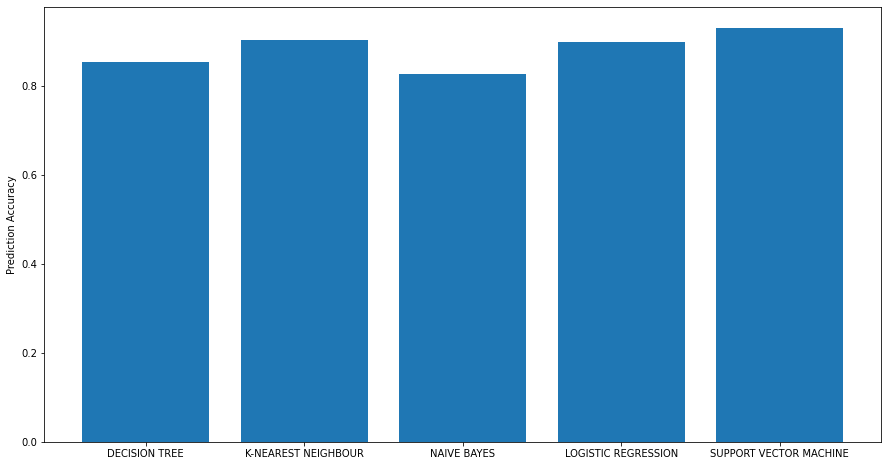

<Figure size 720x720 with 0 Axes>

In [140]:
# Plotting best score accuracy vs models
print(eval_results)
fig, ax = plt.subplots(figsize=(15,8))
ax.set_ylabel('Prediction Accuracy')
plt.figure(figsize=(10,10))
ax.bar(eval_results.index, eval_results['Accuracy'])

#### PCA reduction

In [ ]:
# Perform simple PCA reduction to 98% variance
pca = PCA(n_components=0.98,random_state=42)
X_train_reduced = pca.fit_transform(X_train)

print(pca.n_components_)
print(pca.explained_variance_ratio_)
print(pca.n_features_in_)

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=10, random_state=42, max_iter=1000).fit(X_train_reduced, y_train)

X_test_reduced = pca.transform(X_test)
print("Accuracy on training set: {:.3f}".format(clf.score(X_train_reduced, y_train)))
print("Accuracy on test set: {:.3f}".format(clf.score(X_test_reduced, y_test)))

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=10, random_state=42, max_iter=1000).fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(clf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(clf.score(X_test, y_test)))